In [66]:
import numpy as np
import scipy as sp
import scipy.stats

import seaborn 

%matplotlib inline
import matplotlib.pyplot as plt

from exp_family import GaussianDistribution
from projectors import BoxProjector, EigenBoxProjector, CoordProjector
from optimizers import projected_gradient

In [41]:
np.random.seed(122)
obj = lambda x: x[0] * sp.stats.multivariate_normal.pdf(x, mean=[14, 14], cov=np.diag([1.2, 1.2]))
projector = CoordProjector(BoxProjector(-5, 5), EigenBoxProjector(1, 15))

In [42]:
thetas, estimations = projected_gradient(obj, GaussianDistribution, projector, 
                                         1e-6, (np.array([2, 2]), np.eye(2)), n_iters=2 * 10 ** 5)

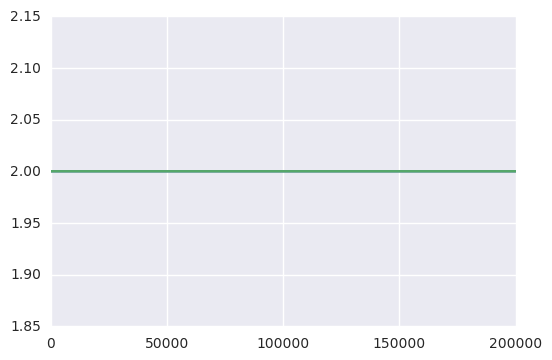

In [43]:
# plot mu history, should converge to 4,4
mu = [np.linalg.pinv(x[1]).dot(x[0]) for x in thetas]
plt.plot(mu)

In [44]:
thetas[-1]

(array([ 2.,  2.]), array([[  1.00000000e+00,  -2.23711432e-17],
        [ -2.23711432e-17,   1.00000000e+00]]))

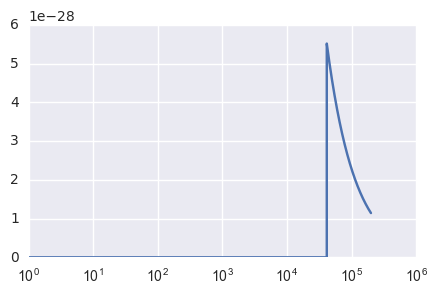

In [45]:
plt.figure(figsize=(5, 3))
plt.plot(np.array(estimations))
plt.xscale('log')

In [46]:
estimations[-10:]

[1.1433080378674877e-28,
 1.1433023210986275e-28,
 1.1432966043869372e-28,
 1.1432908877324156e-28,
 1.143285171135062e-28,
 1.1432794545948755e-28,
 1.1432737381118553e-28,
 1.1432680216860005e-28,
 1.1432623053173101e-28,
 1.1432565890057835e-28]

In [62]:
scipy.special.gamma(6)

120.0

In [63]:
scipy.special.psi(1)

-0.57721566490153309

In [68]:
def _dot(a, b):
    return sum(np.inner(x.ravel(), y.ravel()) for x, y in zip(a, b))


class ExponentialFamilyDistribution(object):
    def __init__(self, *theta):
        self.theta = theta

    def A(self):
        return NotImplemented

    def T(self, x):
        return NotImplemented

    def h(self, x):
        return NotImplemented

    def pdf(self, x):
        return self.h(x) * np.exp(_dot(self.theta, self.T(x)) - self.A())

    def sample(self):
        raise NotImplemented

In [125]:
import numpy as np
import scipy as sp

class DirichletDistribution(ExponentialFamilyDistribution):
    def __init__(self, *theta):
        super(DirichletDistribution, self).__init__(*theta)


        # thetas are original parameters alpha of dirichlet distribution 
        self.theta = theta

    def A(self):
        return np.log(np.sum(sp.special.gamma(self.theta))) - np.log(sp.special.gamma(np.sum(self.theta)))

    def grad_A(self):
        grad = [sp.special.psi(self.theta[i]) / sp.special.gamma(self.theta[i]) - sp.special.psi(np.sum(self.theta[i])) / sp.special.gamma(np.sum(self.theta[i])) for i in range(len(self.theta))]
        return grad

    def T(self, x):
        return np.log(x)

    def h(self, x):
        return 1./np.exp(np.log(x).sum())

    def sample(self):
        return np.random.dirichlet(np.array(self.theta))